In [3]:
import torch
import torchvision
import torchvision.transforms as T
import pandas as pd
from PIL import Image
import os
import logging
from torch.utils.data import Dataset
import torch.nn as nn

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch version: 2.5.1+cu118
Device: cuda


In [4]:
acuity_path = "../Choithram Netralaya Data/acuityvalues.xlsx"

df = pd.read_excel(acuity_path)

display(df.head())

print("Columns in the dataset:")
print(df.columns)

,patient,r sphere,r cylinder,l sphere,l cylinder
0,1,0.25,-0.25,0.00,-0.25
1,2,-0.50,-0.50,0.00,-0.50
2,3,1.75,-0.75,0.00,-0.25
3,4,0.25,0.00,0.25,0.00
4,5,0.25,0.25,0.25,0.00


Columns in the dataset:
Index(['patient', 'r sphere', 'r cylinder', 'l sphere', 'l cylinder'], dtype='object')


In [5]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

filtered_df = df.copy()
numeric_cols = ['r sphere', 'r cylinder', 'l sphere', 'l cylinder']

filtered_df = filtered_df.dropna(subset=numeric_cols)

df_patients = set(map(str, filtered_df['patient'].unique()))

data_dir = "../Choithram Netralaya Data/Images"
image_patients = set()
if os.path.exists(data_dir):
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            image_patients.add(folder_name)
else:
    logging.warning("Image directory does not exist!")

all_patients = df_patients.union(image_patients)

valid_patients = []
logging.info(f"Total patients in DF (after NaN drop): {len(df_patients)}")
logging.info(f"Total patients in image directory: {len(image_patients)}")
logging.info(f"Combined unique patients: {len(all_patients)}")

for patient_id in sorted(all_patients, key=lambda x: int(x)):
    if patient_id not in df_patients:
        logging.info(f"Skipping patient {patient_id}: no numeric values found in DataFrame.")
        continue
    row = filtered_df.loc[filtered_df['patient'] == int(patient_id)].head(1)
    if row.empty:
        logging.info(f"Skipping patient {patient_id}: filtered out due to missing numeric data.")
        continue

    left_ir_path = os.path.join(data_dir, patient_id, f"{patient_id}_LEFT_IR.jpg")
    right_ir_path = os.path.join(data_dir, patient_id, f"{patient_id}_RIGHT_IR.jpg")

    left_exists = os.path.exists(left_ir_path)
    right_exists = os.path.exists(right_ir_path)

    if not left_exists and not right_exists:
        logging.info(f"Skipping patient {patient_id}: LEFT_IR and RIGHT_IR images missing.")
        continue
    elif not left_exists:
        logging.info(f"Skipping patient {patient_id}: LEFT_IR image missing.")
        continue
    elif not right_exists:
        logging.info(f"Skipping patient {patient_id}: RIGHT_IR image missing.")
        continue

    logging.info(f"Including patient {patient_id}: Numeric and IR images available.")
    valid_patients.append(patient_id)

valid_patient_ids = set(map(int, valid_patients))
filtered_df = filtered_df[filtered_df['patient'].isin(valid_patient_ids)].reset_index(drop=True)

logging.info(f"Number of valid patients after filtering: {len(filtered_df)}")


INFO: Total patients in DF (after NaN drop): 302
INFO: Total patients in image directory: 343
INFO: Combined unique patients: 343
INFO: Skipping patient 1: LEFT_IR image missing.
INFO: Including patient 2: Numeric and IR images available.
INFO: Including patient 3: Numeric and IR images available.
INFO: Including patient 4: Numeric and IR images available.
INFO: Including patient 5: Numeric and IR images available.
INFO: Including patient 6: Numeric and IR images available.
INFO: Including patient 7: Numeric and IR images available.
INFO: Including patient 8: Numeric and IR images available.
INFO: Including patient 9: Numeric and IR images available.
INFO: Including patient 10: Numeric and IR images available.
INFO: Including patient 11: Numeric and IR images available.
INFO: Including patient 12: Numeric and IR images available.
INFO: Including patient 13: Numeric and IR images available.
INFO: Including patient 14: Numeric and IR images available.
INFO: Including patient 15: Numeric 

In [6]:
class EyeIRDataset(Dataset):
    def __init__(self, df, data_dir, transform=None, is_training=True):
        """
        Args:
            df (DataFrame): Data containing patient IDs and numerical features.
            data_dir (str): Directory where images are stored.
            transform: Image transformations.
            is_training (bool): Whether the dataset is for training or testing.
        """
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Use patient_id internally for loading images
        patient_id = str(int(row['patient']))
        left_ir_path = os.path.join(self.data_dir, patient_id, f"{patient_id}_LEFT_IR.jpg")
        right_ir_path = os.path.join(self.data_dir, patient_id, f"{patient_id}_RIGHT_IR.jpg")

        left_img = Image.open(left_ir_path).convert("RGB")
        right_img = Image.open(right_ir_path).convert("RGB")

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        # For training, include numeric features and targets
        if self.is_training:
            numeric_features = torch.tensor(
                [row['r sphere'], row['r cylinder'], row['l sphere'], row['l cylinder']],
                dtype=torch.float
            )
            target = numeric_features.clone()  # Targets are the same as numeric features
            return {
                "left_ir": left_img,
                "right_ir": right_img,
                "numeric_features": numeric_features,
                "target": target
            }
        else:  # For testing, only return images
            return {
                "left_ir": left_img,
                "right_ir": right_img
            }


In [7]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

data_dir = "../Choithram Netralaya Data/Images"
dataset = EyeIRDataset(filtered_df, data_dir, transform=transform)

In [33]:
sample = dataset[0]

print("Keys in sample:", sample.keys())
print("Left IR image shape:", sample['left_ir'].shape)
print("Right IR image shape:", sample['right_ir'].shape)
print("Numeric features:", sample['numeric_features'])
print("Target:", sample['target'])


Keys in sample: dict_keys(['left_ir', 'right_ir', 'numeric_features', 'target'])
Left IR image shape: torch.Size([3, 224, 224])
Right IR image shape: torch.Size([3, 224, 224])
Numeric features: tensor([-0.5000, -0.5000,  0.0000, -0.5000])
Target: tensor([-0.5000, -0.5000,  0.0000, -0.5000])


## Model

In [9]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load pretrained EfficientNet B0
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Remove the last classification layer (classifier)
effnet.classifier = nn.Identity()
print(effnet)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EyeModel(nn.Module):
    def __init__(self, output_dim=4):
        super(EyeModel, self).__init__()
        # EfficientNet for image processing
        self.cnn = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.cnn.classifier = nn.Identity()  # Remove classifier

        # Fully connected layer to compress combined image features
        self.img_compress = nn.Sequential(
            nn.Linear(1280 * 2, 512),  # 1280 features from each image (left & right)
            nn.ReLU(),
            nn.Dropout(0.3)  # Add dropout for better regularization
        )

        # Small MLP for numeric features
        self.numeric_branch = nn.Sequential(
            nn.Linear(4, 64),  # Input: 4 numeric features
            nn.ReLU(),
            nn.Linear(64, 32),  # Output: 32 numeric features
            nn.ReLU()
        )

        # Final fully connected layer for predictions
        self.fc = nn.Sequential(
            nn.Linear(512 + 32, 128),  # Combine image (512) and numeric features (32)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_dim)  # Predict 4 outputs: r sphere, r cylinder, l sphere, l cylinder
        )

    def forward(self, left_ir, right_ir, numeric=None):
        """
        Forward pass for the model.
        Args:
            left_ir (Tensor): Left eye IR image tensor.
            right_ir (Tensor): Right eye IR image tensor.
            numeric (Tensor or None): Numeric features (optional during inference).
        Returns:
            Tensor: Predicted values for [r sphere, r cylinder, l sphere, l cylinder].
        """
        # Extract features from the left and right IR images
        left_feat = self.cnn(left_ir)  # [batch_size, 1280]
        right_feat = self.cnn(right_ir)  # [batch_size, 1280]

        # Combine and compress image features
        combined_img_feat = torch.cat([left_feat, right_feat], dim=1)  # [batch_size, 2560]
        combined_img_feat = self.img_compress(combined_img_feat)  # [batch_size, 512]

        if numeric is not None:
            # Process numeric features and fuse with image features
            numeric_feat = self.numeric_branch(numeric)  # [batch_size, 32]
            fused_feat = torch.cat([combined_img_feat, numeric_feat], dim=1)  # [batch_size, 512 + 32]
        else:
            # If no numeric features are provided, use only image features
            fused_feat = combined_img_feat  # [batch_size, 512]

        # Final prediction
        out = self.fc(fused_feat)  # [batch_size, output_dim]
        return out


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = EyeModel(output_dim=4).to(device)

# Define the optimizer and loss function
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Print model summary
print(model)

EyeModel(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Split dataset indices
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Updated With Cosine

In [38]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01, verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            verbose (bool): Whether to print early stopping messages.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered!")
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)

# Initialize model, optimizer, criterion, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EyeModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30)  # 30 epochs for cosine cycle

# Training and Validation Functions
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for batch in train_loader:
        left_ir = batch['left_ir'].to(device)
        right_ir = batch['right_ir'].to(device)
        numeric = batch['numeric_features'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = model(left_ir, right_ir, numeric)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

def validate_one_epoch(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            left_ir = batch['left_ir'].to(device)
            right_ir = batch['right_ir'].to(device)
            numeric = batch['numeric_features'].to(device)
            target = batch['target'].to(device)

            output = model(left_ir, right_ir, numeric)
            loss = criterion(output, target)
            val_loss += loss.item()

    return val_loss / len(test_loader)

# Training Loop
epochs = 30
best_val_loss = float("inf")

for epoch in range(epochs):
    # Training Phase
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation Phase
    val_loss = validate_one_epoch(model, test_loader, criterion, device)

    # Step the scheduler
    scheduler.step()

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")

    # Log Epoch Details
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch [1/30], Train Loss: 15.4191, Val Loss: 13.4205, LR: 0.000100
Epoch [2/30], Train Loss: 11.6511, Val Loss: 11.8360, LR: 0.000099
Epoch [3/30], Train Loss: 8.2498, Val Loss: 10.4522, LR: 0.000098
Epoch [4/30], Train Loss: 7.0994, Val Loss: 9.2449, LR: 0.000096
Epoch [5/30], Train Loss: 6.2793, Val Loss: 10.2972, LR: 0.000093
Epoch [6/30], Train Loss: 6.1481, Val Loss: 8.9662, LR: 0.000090
Epoch [7/30], Train Loss: 6.5764, Val Loss: 9.9489, LR: 0.000087
Epoch [8/30], Train Loss: 4.6869, Val Loss: 9.2207, LR: 0.000083
Epoch [9/30], Train Loss: 5.3224, Val Loss: 8.5678, LR: 0.000079
Epoch [10/30], Train Loss: 5.2871, Val Loss: 8.3871, LR: 0.000075
Epoch [11/30], Train Loss: 4.3687, Val Loss: 7.4897, LR: 0.000070
Epoch [12/30], Train Loss: 4.0036, Val Loss: 7.7036, LR: 0.000065
Epoch [13/30], Train Loss: 3.5229, Val Loss: 7.8762, LR: 0.000060
Epoch [14/30], Train Loss: 3.6331, Val Loss: 7.4845, LR: 0.000055
Epoch [15/30], Train Loss: 3.2977, Val Loss: 7.5553, LR: 0.000050
Epoch [16/30]

In [40]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01, verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered!")
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True)

# Initialize model, optimizer, criterion, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EyeModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

# Metric Calculation Functions
def calculate_metrics(predictions, targets):
    """
    Calculate metrics like MAE, RMSE, and R-squared.
    Args:
        predictions (Tensor): Model predictions.
        targets (Tensor): Ground truth targets.
    Returns:
        tuple: MAE, RMSE, R² metrics.
    """
    # Detach predictions and targets from computation graph and convert to NumPy
    predictions = predictions.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    mae = np.mean(np.abs(predictions - targets))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))  # Root Mean Squared Error
    r_squared = 1 - (np.sum((targets - predictions) ** 2) / np.sum((targets - np.mean(targets)) ** 2))  # R²
    return mae, rmse, r_squared

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    mae_total, rmse_total, r2_total = 0, 0, 0
    for batch in train_loader:
        left_ir = batch['left_ir'].to(device)
        right_ir = batch['right_ir'].to(device)
        numeric = batch['numeric_features'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        predictions = model(left_ir, right_ir, numeric)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate metrics
        mae, rmse, r_squared = calculate_metrics(predictions, target)
        mae_total += mae
        rmse_total += rmse
        r2_total += r_squared

    total_loss /= len(train_loader)
    mae_total /= len(train_loader)
    rmse_total /= len(train_loader)
    r2_total /= len(train_loader)
    return total_loss, mae_total, rmse_total, r2_total

def validate_one_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    mae_total, rmse_total, r2_total = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            left_ir = batch['left_ir'].to(device)
            right_ir = batch['right_ir'].to(device)
            numeric = batch['numeric_features'].to(device)
            target = batch['target'].to(device)

            predictions = model(left_ir, right_ir, numeric)
            loss = criterion(predictions, target)
            total_loss += loss.item()

            # Calculate metrics
            mae, rmse, r_squared = calculate_metrics(predictions, target)
            mae_total += mae
            rmse_total += rmse
            r2_total += r_squared

    total_loss /= len(test_loader)
    mae_total /= len(test_loader)
    rmse_total /= len(test_loader)
    r2_total /= len(test_loader)
    return total_loss, mae_total, rmse_total, r2_total

# Training Loop
epochs = 30
best_val_loss = float("inf")

for epoch in range(epochs):
    # Training Phase
    train_loss, train_mae, train_rmse, train_r2 = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation Phase
    val_loss, val_mae, val_rmse, val_r2 = validate_one_epoch(model, test_loader, criterion, device)

    # Step the scheduler
    scheduler.step()

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")

    # Log Epoch Details
    current_lr = scheduler.get_last_lr()[0]
    print(
        f"Epoch [{epoch+1}/{epochs}], LR: {current_lr:.6f}\n"
        f"Train Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}\n"
        f"Val Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}"
    )

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


Epoch [1/30], LR: 0.000100
Train Loss: 15.9619, MAE: 2.4593, RMSE: 3.8313, R²: -0.3251
Val Loss: 13.7721, MAE: 2.1126, RMSE: 3.3014, R²: -0.1747
Epoch [2/30], LR: 0.000099
Train Loss: 12.5561, MAE: 2.1613, RMSE: 3.3106, R²: -0.0824
Val Loss: 12.1340, MAE: 2.0821, RMSE: 3.1973, R²: -0.1852
Epoch [3/30], LR: 0.000098
Train Loss: 9.6347, MAE: 1.9677, RMSE: 3.0051, R²: 0.0313
Val Loss: 11.0216, MAE: 2.0968, RMSE: 3.1800, R²: -0.3377
Epoch [4/30], LR: 0.000096
Train Loss: 7.2194, MAE: 1.8501, RMSE: 2.6262, R²: 0.1549
Val Loss: 9.9381, MAE: 1.9565, RMSE: 3.0165, R²: -0.1417
Epoch [5/30], LR: 0.000093
Train Loss: 6.2857, MAE: 1.7438, RMSE: 2.4230, R²: 0.1486
Val Loss: 9.6061, MAE: 1.8553, RMSE: 2.9173, R²: -0.0082
Epoch [6/30], LR: 0.000090
Train Loss: 6.7712, MAE: 1.7035, RMSE: 2.4876, R²: 0.2647
Val Loss: 7.8964, MAE: 1.8100, RMSE: 2.7151, R²: 0.0316
Epoch [7/30], LR: 0.000087
Train Loss: 5.2692, MAE: 1.5871, RMSE: 2.2326, R²: 0.4626
Val Loss: 8.2390, MAE: 1.7888, RMSE: 2.7157, R²: 0.1180
E

In [13]:
# Used This before Data pipline update
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        left_ir = batch['left_ir'].to(device)
        right_ir = batch['right_ir'].to(device)
        numeric = batch['numeric_features'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = model(left_ir, right_ir, numeric)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluate on the test set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            left_ir = batch['left_ir'].to(device)
            right_ir = batch['right_ir'].to(device)
            numeric = batch['numeric_features'].to(device)
            target = batch['target'].to(device)

            output = model(left_ir, right_ir, numeric)
            loss = criterion(output, target)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

Epoch [1/30], Train Loss: 13.8399, Val Loss: 12.9009
Epoch [2/30], Train Loss: 9.2904, Val Loss: 11.0096
Epoch [3/30], Train Loss: 7.6771, Val Loss: 9.7980
Epoch [4/30], Train Loss: 6.0138, Val Loss: 9.5703
Epoch [5/30], Train Loss: 4.5280, Val Loss: 9.8843
Epoch [6/30], Train Loss: 4.4371, Val Loss: 7.4861
Epoch [7/30], Train Loss: 4.3419, Val Loss: 6.7708
Epoch [8/30], Train Loss: 3.5068, Val Loss: 6.7393
Epoch [9/30], Train Loss: 2.9684, Val Loss: 6.1609
Epoch [10/30], Train Loss: 2.7910, Val Loss: 4.6760
Epoch [11/30], Train Loss: 2.5522, Val Loss: 4.6998
Epoch [12/30], Train Loss: 2.2022, Val Loss: 4.0962
Epoch [13/30], Train Loss: 1.6055, Val Loss: 3.7527
Epoch [14/30], Train Loss: 1.8538, Val Loss: 3.7807
Epoch [15/30], Train Loss: 1.4954, Val Loss: 3.1643
Epoch [16/30], Train Loss: 1.5853, Val Loss: 2.7448
Epoch [17/30], Train Loss: 1.2036, Val Loss: 2.8373
Epoch [18/30], Train Loss: 1.1247, Val Loss: 2.6587
Epoch [19/30], Train Loss: 1.1769, Val Loss: 3.0289
Epoch [20/30], Tra

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for batch_data in dataloader:
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            total_loss += loss.item() * left_ir.size(0)
            count += left_ir.size(0)

    avg_loss = total_loss / count if count > 0 else 0
    return avg_loss

# Evaluate on test set
test_loss = evaluate(model, test_loader, criterion, device)
print("Final Test Loss:", test_loss)


Final Test Loss: 1.5623051998978954


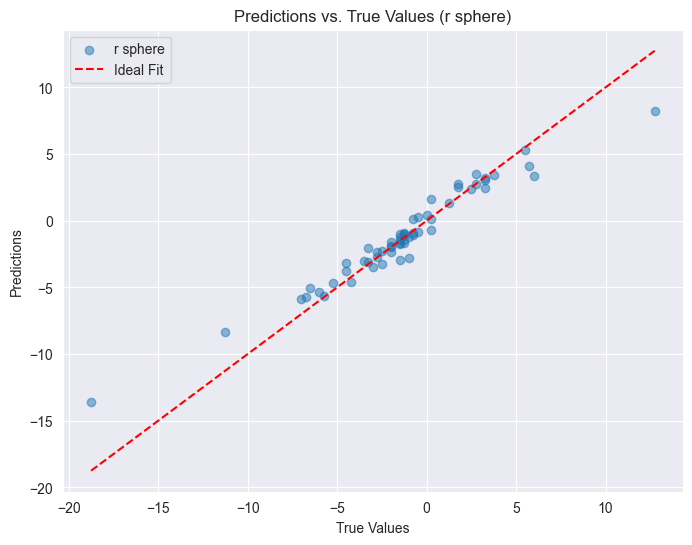

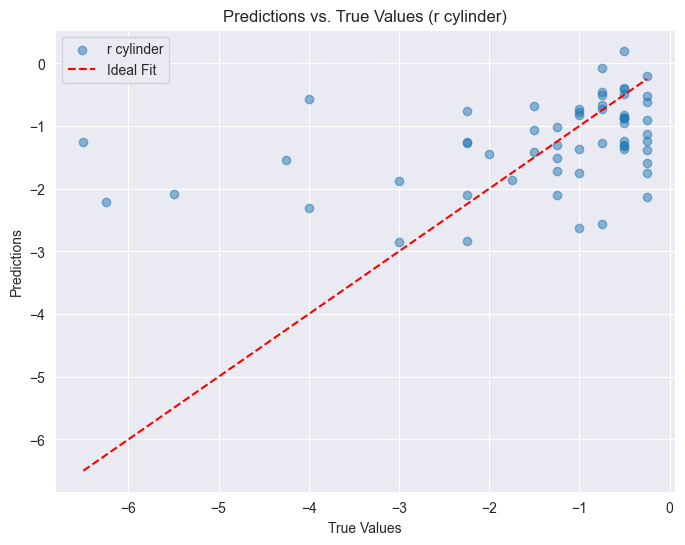

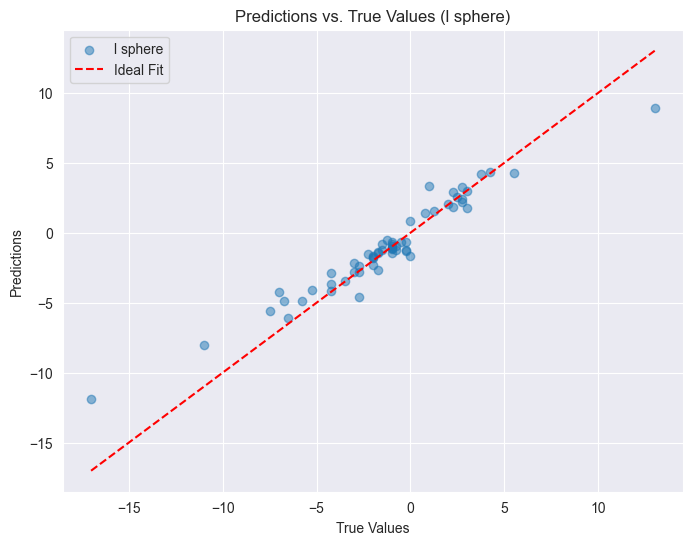

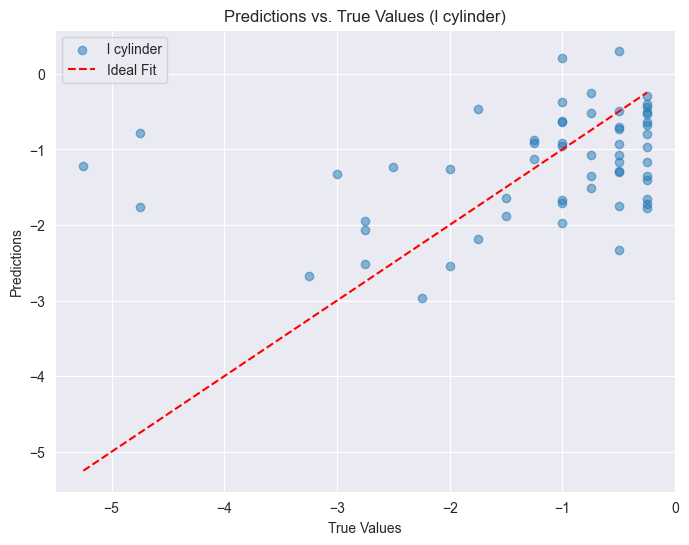

In [15]:
import matplotlib.pyplot as plt

predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        pred = model(left_ir, right_ir, numeric)
        predictions.append(pred.cpu())
        targets.append(target.cpu())

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

# Plot predictions vs. true values for each feature
feature_names = ['r sphere', 'r cylinder', 'l sphere', 'l cylinder']
for i in range(4):
    plt.figure(figsize=(8, 6))
    plt.scatter(targets[:, i], predictions[:, i], alpha=0.5, label=feature_names[i])
    plt.plot([min(targets[:, i]), max(targets[:, i])], [min(targets[:, i]), max(targets[:, i])], 'r--', label="Ideal Fit")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"Predictions vs. True Values ({feature_names[i]})")
    plt.legend()
    plt.show()


In [16]:
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the model
model_save_path = f"efficientnet_eye_model_{timestamp}.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at efficientnet_eye_model_20241215_011938.pth


## Hyperparameter Tuning

In [20]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training loop
epochs = 30
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    train_count = 0
    for batch_data in train_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        total_train_loss += loss.item() * left_ir.size(0)
        train_count += left_ir.size(0)

    avg_train_loss = total_train_loss / train_count

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_count = 0
    with torch.no_grad():
        for batch_data in test_loader:
            # Move data to device
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            # Forward pass
            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            # Accumulate validation loss
            total_val_loss += loss.item() * left_ir.size(0)
            val_count += left_ir.size(0)

    avg_val_loss = total_val_loss / val_count if val_count > 0 else 0

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Log training and validation loss
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Current Learning Rate: {current_lr}")

# Final Test Phase
model.eval()
total_test_loss = 0
test_count = 0
with torch.no_grad():
    for batch_data in test_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Accumulate test loss
        total_test_loss += loss.item() * left_ir.size(0)
        test_count += left_ir.size(0)

avg_test_loss = total_test_loss / test_count if test_count > 0 else 0
print(f"Final Test Loss: {avg_test_loss:.4f}")

Epoch [1/30], Train Loss: 0.7583, Val Loss: 1.6281
Current Learning Rate: 0.0001
Epoch [2/30], Train Loss: 0.7685, Val Loss: 1.5584
Current Learning Rate: 0.0001
Epoch [3/30], Train Loss: 0.7126, Val Loss: 1.5471
Current Learning Rate: 0.0001
Epoch [4/30], Train Loss: 0.7680, Val Loss: 1.4492
Current Learning Rate: 0.0001
Epoch [5/30], Train Loss: 0.7201, Val Loss: 1.3724
Current Learning Rate: 0.0001
Epoch [6/30], Train Loss: 0.6261, Val Loss: 1.3760
Current Learning Rate: 0.0001
Epoch [7/30], Train Loss: 0.5255, Val Loss: 1.3941
Current Learning Rate: 0.0001
Epoch [8/30], Train Loss: 0.6256, Val Loss: 1.4265
Current Learning Rate: 0.0001
Epoch [9/30], Train Loss: 0.7105, Val Loss: 1.3713
Current Learning Rate: 0.0001
Epoch [10/30], Train Loss: 0.7146, Val Loss: 1.3398
Current Learning Rate: 0.0001
Epoch [11/30], Train Loss: 0.5441, Val Loss: 1.2940
Current Learning Rate: 0.0001
Epoch [12/30], Train Loss: 0.6065, Val Loss: 1.2498
Current Learning Rate: 0.0001
Epoch [13/30], Train Loss

In [21]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Option 1: Use ReduceLROnPlateau with a smaller threshold
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, threshold=1e-6)

# Option 2: Use CosineAnnealingLR
# scheduler_cosine = CosineAnnealingLR(optimizer, T_max=30)  # T_max = total epochs

# Select the scheduler
scheduler = scheduler_plateau
# scheduler = scheduler_cosine

# Training loop
epochs = 30
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    train_count = 0
    for batch_data in train_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        total_train_loss += loss.item() * left_ir.size(0)
        train_count += left_ir.size(0)

    avg_train_loss = total_train_loss / train_count

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_count = 0
    with torch.no_grad():
        for batch_data in test_loader:
            # Move data to device
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            # Forward pass
            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            # Accumulate validation loss
            total_val_loss += loss.item() * left_ir.size(0)
            val_count += left_ir.size(0)

    avg_val_loss = total_val_loss / val_count if val_count > 0 else 0

    # Step the learning rate scheduler
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()

    # Log training and validation loss
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Current Learning Rate: {current_lr}")

# Final Test Phase
model.eval()
total_test_loss = 0
test_count = 0
with torch.no_grad():
    for batch_data in test_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Accumulate test loss
        total_test_loss += loss.item() * left_ir.size(0)
        test_count += left_ir.size(0)

avg_test_loss = total_test_loss / test_count if test_count > 0 else 0
print(f"Final Test Loss: {avg_test_loss:.4f}")


Epoch [1/30], Train Loss: 0.3880, Val Loss: 1.0241
Current Learning Rate: 0.0001
Epoch [2/30], Train Loss: 0.4282, Val Loss: 0.9598
Current Learning Rate: 0.0001
Epoch [3/30], Train Loss: 0.4234, Val Loss: 1.0075
Current Learning Rate: 0.0001
Epoch [4/30], Train Loss: 0.4541, Val Loss: 0.9302
Current Learning Rate: 0.0001
Epoch [5/30], Train Loss: 0.4389, Val Loss: 0.9684
Current Learning Rate: 0.0001
Epoch [6/30], Train Loss: 0.3753, Val Loss: 0.9392
Current Learning Rate: 0.0001
Epoch [7/30], Train Loss: 0.3919, Val Loss: 0.9510
Current Learning Rate: 0.0001
Epoch [8/30], Train Loss: 0.3972, Val Loss: 0.9567
Current Learning Rate: 5e-05
Epoch [9/30], Train Loss: 0.3588, Val Loss: 0.8982
Current Learning Rate: 5e-05
Epoch [10/30], Train Loss: 0.3890, Val Loss: 0.8670
Current Learning Rate: 5e-05
Epoch [11/30], Train Loss: 0.3003, Val Loss: 0.8950
Current Learning Rate: 5e-05
Epoch [12/30], Train Loss: 0.3989, Val Loss: 0.8663
Current Learning Rate: 5e-05
Epoch [13/30], Train Loss: 0.3

### Cosine

In [24]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Option 1: Use ReduceLROnPlateau with a smaller threshold
# scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, threshold=1e-6)

# Option 2: Use CosineAnnealingLR
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=30)  # T_max = total epochs

# Select the scheduler (Uncomment the desired option)
# scheduler = scheduler_plateau
scheduler = scheduler_cosine

# Training loop
epochs = 30
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    train_count = 0
    for batch_data in train_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        optimizer.zero_grad()
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        total_train_loss += loss.item() * left_ir.size(0)
        train_count += left_ir.size(0)

    avg_train_loss = total_train_loss / train_count

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_count = 0
    with torch.no_grad():
        for batch_data in test_loader:
            # Move data to device
            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            numeric = batch_data['numeric_features'].to(device)
            target = batch_data['target'].to(device)

            # Forward pass
            pred = model(left_ir, right_ir, numeric)
            loss = criterion(pred, target)

            # Accumulate validation loss
            total_val_loss += loss.item() * left_ir.size(0)
            val_count += left_ir.size(0)

    avg_val_loss = total_val_loss / val_count if val_count > 0 else 0

    # Step the learning rate scheduler
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()

    # Log training and validation loss
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Current Learning Rate: {current_lr}")

# Final Test Phase
model.eval()
total_test_loss = 0
test_count = 0
with torch.no_grad():
    for batch_data in test_loader:
        # Move data to device
        left_ir = batch_data['left_ir'].to(device)
        right_ir = batch_data['right_ir'].to(device)
        numeric = batch_data['numeric_features'].to(device)
        target = batch_data['target'].to(device)

        # Forward pass
        pred = model(left_ir, right_ir, numeric)
        loss = criterion(pred, target)

        # Accumulate test loss
        total_test_loss += loss.item() * left_ir.size(0)
        test_count += left_ir.size(0)

avg_test_loss = total_test_loss / test_count if test_count > 0 else 0
print(f"Final Test Loss: {avg_test_loss:.4f}")


Epoch [1/30], Train Loss: 0.3805, Val Loss: 0.9036
Current Learning Rate: 9.972609476841367e-05
Epoch [2/30], Train Loss: 0.4026, Val Loss: 0.8587
Current Learning Rate: 9.890738003669029e-05
Epoch [3/30], Train Loss: 0.3542, Val Loss: 0.8762
Current Learning Rate: 9.755282581475769e-05
Epoch [4/30], Train Loss: 0.3452, Val Loss: 0.8239
Current Learning Rate: 9.567727288213003e-05
Epoch [5/30], Train Loss: 0.3636, Val Loss: 0.8340
Current Learning Rate: 9.330127018922194e-05
Epoch [6/30], Train Loss: 0.4178, Val Loss: 0.8425
Current Learning Rate: 9.045084971874738e-05
Epoch [7/30], Train Loss: 0.3078, Val Loss: 0.8622
Current Learning Rate: 8.715724127386972e-05
Epoch [8/30], Train Loss: 0.3809, Val Loss: 0.8259
Current Learning Rate: 8.345653031794292e-05
Epoch [9/30], Train Loss: 0.2884, Val Loss: 0.8557
Current Learning Rate: 7.938926261462366e-05
Epoch [10/30], Train Loss: 0.3606, Val Loss: 0.8497
Current Learning Rate: 7.500000000000001e-05
Epoch [11/30], Train Loss: 0.2681, Val 

## Analysis on scheduler_plateau

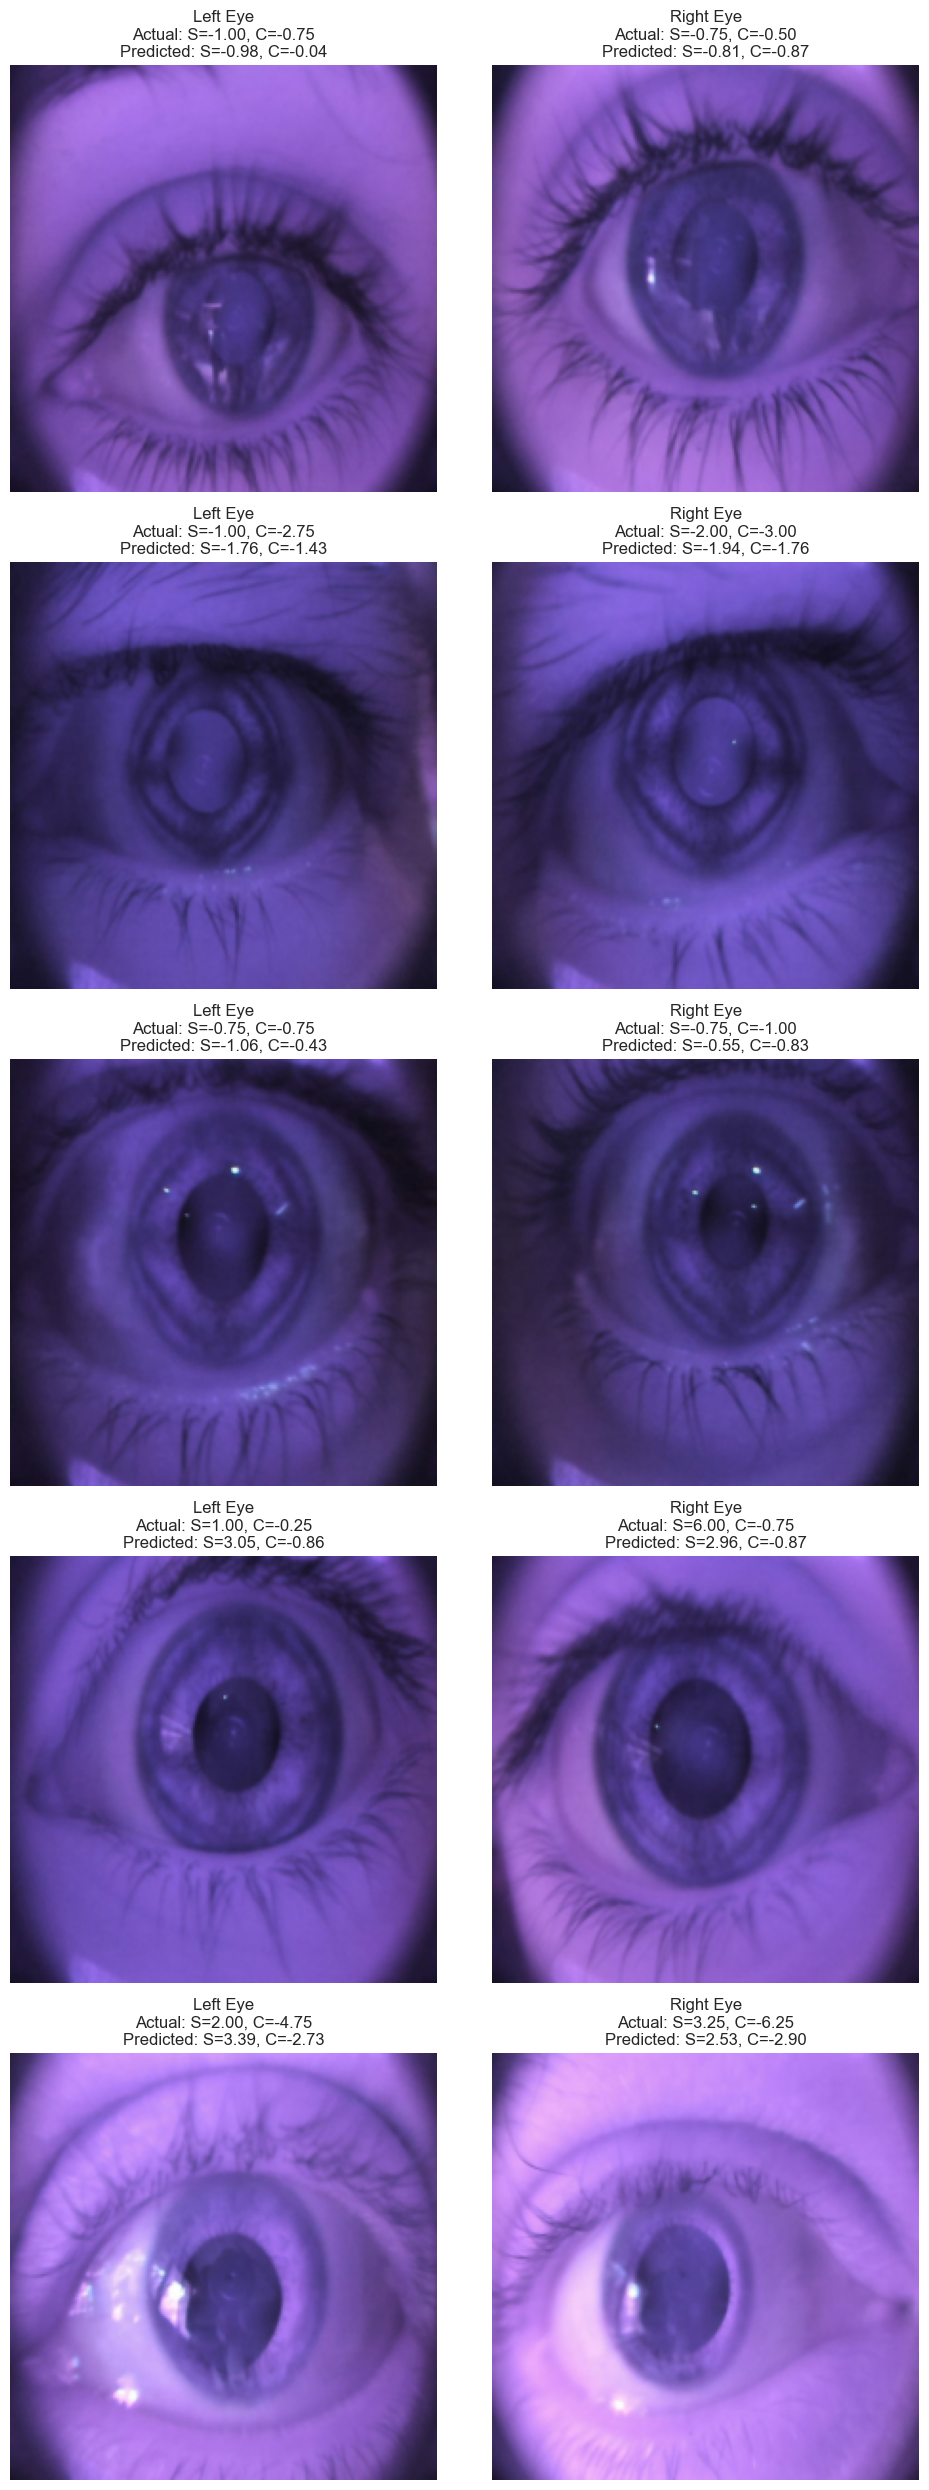

In [22]:
import matplotlib.pyplot as plt

# Helper function to show predictions vs actual values
def visualize_predictions(model, dataset, device, n_samples=5):
    model.eval()
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5 * n_samples))

    with torch.no_grad():
        for i in range(n_samples):
            # Get a sample from the dataset
            sample = dataset[i]
            left_ir = sample['left_ir'].unsqueeze(0).to(device)  # Add batch dimension
            right_ir = sample['right_ir'].unsqueeze(0).to(device)
            numeric = sample['numeric_features'].unsqueeze(0).to(device)
            target = sample['target']

            # Get predictions
            pred = model(left_ir, right_ir, numeric).squeeze().cpu()

            # Extract actual and predicted values
            actual = target.numpy()
            predicted = pred.numpy()

            # Show images
            left_image = sample['left_ir'].permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
            right_image = sample['right_ir'].permute(1, 2, 0).cpu().numpy()

            # Display left IR image
            axes[i, 0].imshow(left_image)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(
                f"Left Eye\nActual: S={actual[2]:.2f}, C={actual[3]:.2f}\n"
                f"Predicted: S={predicted[2]:.2f}, C={predicted[3]:.2f}"
            )

            # Display right IR image
            axes[i, 1].imshow(right_image)
            axes[i, 1].axis('off')
            axes[i, 1].set_title(
                f"Right Eye\nActual: S={actual[0]:.2f}, C={actual[1]:.2f}\n"
                f"Predicted: S={predicted[0]:.2f}, C={predicted[1]:.2f}"
            )

    plt.tight_layout()
    plt.show()


# Visualize predictions on test dataset
visualize_predictions(model, test_dataset, device, n_samples=5)


### Cosine Analysis


In [42]:
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Helper function to visualize predictions
def visualize_predictions(test_loader, model, device, num_samples=5):
    model.eval()
    count = 0
    with torch.no_grad():
        for batch_data in test_loader:
            if count >= num_samples:
                break

            left_ir = batch_data['left_ir'].to(device)
            right_ir = batch_data['right_ir'].to(device)
            target = batch_data['target'].cpu().numpy()

            # Get predictions
            predictions = model(left_ir, right_ir, None)
            predictions = predictions.cpu().numpy()

            for i in range(left_ir.size(0)):
                if count >= num_samples:
                    break

                # Convert images to displayable format
                left_img = left_ir[i].permute(1, 2, 0).cpu().numpy()
                right_img = right_ir[i].permute(1, 2, 0).cpu().numpy()

                # Plot the images and values
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(left_img)
                axes[0].axis('off')
                axes[0].set_title(
                    f"Left Eye\nActual: S={target[i][0]:.2f}, C={target[i][1]:.2f}\n"
                    f"Predicted: S={predictions[i][0]:.2f}, C={predictions[i][1]:.2f}"
                )

                axes[1].imshow(right_img)
                axes[1].axis('off')
                axes[1].set_title(
                    f"Right Eye\nActual: S={target[i][2]:.2f}, C={target[i][3]:.2f}\n"
                    f"Predicted: S={predictions[i][2]:.2f}, C={predictions[i][3]:.2f}"
                )

                plt.tight_layout()
                plt.show()

                count += 1

# Visualize predictions on test dataset
visualize_predictions(test_loader, model, device, num_samples=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x512 and 544x128)